In [ ]:
pip install dgl

In [ ]:
pip install category_encoders

In [ ]:
import dgl.nn as dglnn
from dgl import from_networkx
import torch.nn as nn
import torch as th
import torch.nn.functional as F
import dgl.function as fn
import networkx as nx
import pandas as pd
import socket
import struct
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
data = pd.read_csv('/content/NF-BoT-IoT.csv')


In [ ]:
data

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack
0,192.168.100.6,52670,192.168.100.1,53,17,5.212,71,126,1,1,0,4294966,0,Benign
1,192.168.100.6,49160,192.168.100.149,4444,6,0.000,217753000,199100,4521,4049,24,4176249,1,Theft
2,192.168.100.46,3456,192.168.100.5,80,17,0.000,8508021,8918372,9086,9086,0,4175916,0,Benign
3,192.168.100.3,80,192.168.100.55,8080,6,7.000,8442138,9013406,9086,9086,0,4175916,0,Benign
4,192.168.100.46,80,192.168.100.5,80,6,7.000,8374706,0,9086,0,0,4175916,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,192.168.100.150,54388,192.168.100.3,80,6,7.000,707,710,5,4,27,4282926,1,DDoS
304,192.168.100.150,54388,192.168.100.3,80,6,7.000,707,710,5,4,27,4282926,1,DoS
305,192.168.100.150,54388,192.168.100.3,80,6,7.000,707,710,5,4,27,4282926,1,Reconnaissance
306,192.168.100.150,54394,192.168.100.3,80,6,7.000,663,710,5,4,27,4282927,1,DDoS


In [ ]:
data['IPV4_SRC_ADDR'] = data.IPV4_SRC_ADDR.apply(lambda x: socket.inet_ntoa(struct.pack('>I', random.randint(0xac100001, 0xac1f0001))))

In [ ]:
data['IPV4_SRC_ADDR'] = data.IPV4_SRC_ADDR.apply(str)
data['L4_SRC_PORT'] = data.L4_SRC_PORT.apply(str)
data['IPV4_DST_ADDR'] = data.IPV4_DST_ADDR.apply(str)
data['L4_DST_PORT'] = data.L4_DST_PORT.apply(str)

In [ ]:
data['IPV4_SRC_ADDR'] = data['IPV4_SRC_ADDR'] + ':' + data['L4_SRC_PORT']
data['IPV4_DST_ADDR'] = data['IPV4_DST_ADDR'] + ':' + data['L4_DST_PORT']

In [ ]:
data.drop(columns=['L4_SRC_PORT','L4_DST_PORT'],inplace=True)

In [ ]:
data

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack
0,172.27.188.94:52670,192.168.100.1:53,17,5.212,71,126,1,1,0,4294966,0,Benign
1,172.30.82.114:49160,192.168.100.149:4444,6,0.000,217753000,199100,4521,4049,24,4176249,1,Theft
2,172.21.5.221:3456,192.168.100.5:80,17,0.000,8508021,8918372,9086,9086,0,4175916,0,Benign
3,172.20.50.232:80,192.168.100.55:8080,6,7.000,8442138,9013406,9086,9086,0,4175916,0,Benign
4,172.25.30.122:80,192.168.100.5:80,6,7.000,8374706,0,9086,0,0,4175916,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...
303,172.30.16.20:54388,192.168.100.3:80,6,7.000,707,710,5,4,27,4282926,1,DDoS
304,172.28.23.223:54388,192.168.100.3:80,6,7.000,707,710,5,4,27,4282926,1,DoS
305,172.28.15.15:54388,192.168.100.3:80,6,7.000,707,710,5,4,27,4282926,1,Reconnaissance
306,172.25.251.165:54394,192.168.100.3:80,6,7.000,663,710,5,4,27,4282927,1,DDoS


In [ ]:
data.drop(columns=['Attack'],inplace = True)

In [ ]:
data.rename(columns={"Label": "label"},inplace = True)

In [ ]:
label = data.label

In [ ]:
data.drop(columns=['label'],inplace = True)

In [ ]:
scaler = StandardScaler()

In [ ]:
data =  pd.concat([data, label], axis=1)

In [ ]:
data

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,label
0,172.27.188.94:52670,192.168.100.1:53,17,5.212,71,126,1,1,0,4294966,0
1,172.30.82.114:49160,192.168.100.149:4444,6,0.000,217753000,199100,4521,4049,24,4176249,1
2,172.21.5.221:3456,192.168.100.5:80,17,0.000,8508021,8918372,9086,9086,0,4175916,0
3,172.20.50.232:80,192.168.100.55:8080,6,7.000,8442138,9013406,9086,9086,0,4175916,0
4,172.25.30.122:80,192.168.100.5:80,6,7.000,8374706,0,9086,0,0,4175916,0
...,...,...,...,...,...,...,...,...,...,...,...
303,172.30.16.20:54388,192.168.100.3:80,6,7.000,707,710,5,4,27,4282926,1
304,172.28.23.223:54388,192.168.100.3:80,6,7.000,707,710,5,4,27,4282926,1
305,172.28.15.15:54388,192.168.100.3:80,6,7.000,707,710,5,4,27,4282926,1
306,172.25.251.165:54394,192.168.100.3:80,6,7.000,663,710,5,4,27,4282927,1


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
     data, label, test_size=0.3, random_state=123,stratify= label)

In [ ]:
encoder = ce.TargetEncoder(cols=['TCP_FLAGS','L7_PROTO','PROTOCOL'])
encoder.fit(X_train, y_train)
X_train = encoder.transform(X_train)

In [ ]:
cols_to_norm = list(set(list(X_train.iloc[:, 2:].columns ))  - set(list(['label'])) )
X_train[cols_to_norm] = scaler.fit_transform(X_train[cols_to_norm])

In [ ]:
X_train

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,label
224,172.21.121.31:54334,192.168.100.3:80,0.354478,0.494607,-0.373204,-0.157168,-0.460580,-0.184030,0.559071,0.190381,1
35,172.25.242.174:138,192.168.100.255:138,-2.821052,-2.135145,-0.373275,-0.157193,-0.461565,-0.184810,-1.959496,0.212768,0
280,172.24.231.17:54358,192.168.100.3:80,0.354478,0.494607,-0.373161,-0.157168,-0.460580,-0.184030,0.559071,0.190370,1
131,172.26.149.78:54264,192.168.100.3:80,0.354478,0.494607,-0.373177,-0.157168,-0.460580,-0.184030,0.559071,0.199497,1
264,172.25.91.246:54354,192.168.100.3:80,0.354478,0.494607,-0.373126,-0.157168,-0.460580,-0.184030,0.559071,0.190376,1
...,...,...,...,...,...,...,...,...,...,...,...
139,172.30.223.209:54270,192.168.100.3:80,0.354478,0.494607,-0.373223,-0.157168,-0.460580,-0.184030,0.559071,0.199492,1
255,172.17.198.221:54350,192.168.100.3:80,0.354478,0.494607,-0.373226,-0.157168,-0.460580,-0.184030,0.559071,0.190372,1
55,172.17.109.66:365,192.168.100.3:565,-2.821052,-2.135145,-0.283864,-0.157193,1.218206,-0.184810,-1.959496,-0.010435,0
302,172.26.12.121:54374,192.168.100.3:80,0.354478,0.494607,-0.373240,-0.157168,-0.460580,-0.184030,0.559071,0.190368,1


In [ ]:
X_train['h'] = X_train[ cols_to_norm ].values.tolist()

In [ ]:
G = nx.from_pandas_edgelist(X_train, "IPV4_SRC_ADDR", "IPV4_DST_ADDR", ['h','label'],create_using=nx.MultiGraph())

In [ ]:
G = G.to_directed()

In [ ]:
G = from_networkx(G,edge_attrs=['h','label'] )

In [ ]:
# Eq1
G.ndata['h'] = th.ones(G.num_nodes(), G.edata['h'].shape[1])

In [ ]:
G.edata['train_mask'] = th.ones(len(G.edata['h']), dtype=th.bool)

In [ ]:
G.edata['train_mask']

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, Tr

In [ ]:
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

In [ ]:
class SAGELayer(nn.Module):
    def __init__(self, ndim_in, edims, ndim_out, activation):
        super(SAGELayer, self).__init__()
        ### force to outut fix dimensions
        self.W_msg = nn.Linear(ndim_in + edims, ndim_out)
        ### apply weight
        self.W_apply = nn.Linear(ndim_in + ndim_out, ndim_out)
        self.activation = activation

    def message_func(self, edges):
        return {'m': self.W_msg(th.cat([edges.src['h'], edges.data['h']], 2))}

    def forward(self, g_dgl, nfeats, efeats):
        with g_dgl.local_scope():
            g = g_dgl
            g.ndata['h'] = nfeats
            g.edata['h'] = efeats
            # Eq4
            g.update_all(self.message_func, fn.mean('m', 'h_neigh'))
            # Eq5
            g.ndata['h'] = F.relu(self.W_apply(th.cat([g.ndata['h'], g.ndata['h_neigh']], 2)))
            return g.ndata['h']


class SAGE(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super(SAGE, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(SAGELayer(ndim_in, edim, 128, activation))
        self.layers.append(SAGELayer(128, edim, ndim_out, activation))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, g, nfeats, efeats):
        for i, layer in enumerate(self.layers):
            if i != 0:
                nfeats = self.dropout(nfeats)
            nfeats = layer(g, nfeats, efeats)
        return nfeats.sum(1)

In [ ]:
class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W = nn.Linear(in_features * 2, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        score = self.W(th.cat([h_u, h_v], 1))
        return {'score': score}

    def forward(self, graph, h):
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

In [ ]:
G.ndata['h'] = th.reshape(G.ndata['h'], (G.ndata['h'].shape[0], 1,G.ndata['h'].shape[1]))
G.edata['h'] = th.reshape(G.edata['h'], (G.edata['h'].shape[0], 1,G.edata['h'].shape[1]))

class Model(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super().__init__()
        self.gnn = SAGE(ndim_in, ndim_out, edim, activation, dropout)
        self.pred = MLPPredictor(ndim_out, 2)
    def forward(self, g, nfeats, efeats):
        h = self.gnn(g, nfeats, efeats)
        return self.pred(g, h)

In [ ]:
class Model(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super().__init__()
        self.gnn = SAGE(ndim_in, ndim_out, edim, activation, dropout)
        self.pred = MLPPredictor(ndim_out, 2)
    def forward(self, g, nfeats, efeats):
        h = self.gnn(g, nfeats, efeats)
        return self.pred(g, h)

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight ='balanced',
                                                  classes = np.unique(G.edata['label'].cpu().numpy()),
                                                  y = G.edata['label'].cpu().numpy())

In [ ]:
class_weights

array([2.19387755, 0.64759036])

In [ ]:
class_weights = th.FloatTensor(class_weights).cuda()
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
pip list|grep dgl

dgl                              2.0.0+cu118
dglgo                            0.0.2


In [ ]:
!apt-get update
!apt-get install -y nvidia-cuda-toolkit

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
nvidia-cuda-toolkit is already the newest version (11.5.1-1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [ ]:
print("data" in globals())

True


In [ ]:
import dgl
# G = dgl.DGLGraph()
G = G.to('cuda:0')
print(G.device)

cuda:0


In [ ]:
# Print the keys of the node data dictionary
print(G.ndata.keys())

dict_keys(['h'])


In [ ]:
# Check if the key 'h' exists in the node data dictionary
if 'h' not in G.ndata.keys():
    print("The key 'h' does not exist in the node data dictionary.")

In [ ]:
G.ndata['h'].device

device(type='cuda', index=0)

In [ ]:
G.edata['h'].device

device(type='cuda', index=0)

In [ ]:
node_features = G.ndata['h']
edge_features = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']

model = Model(G.ndata['h'].shape[2], 128, G.ndata['h'].shape[2], F.relu, 0.2).cuda()
opt = th.optim.Adam(model.parameters())

for epoch in range(1,5500):
    pred = model(G, node_features,edge_features).cuda()
    loss = criterion(pred[train_mask] ,edge_label[train_mask])
    opt.zero_grad()
    loss.backward()
    opt.step()
    if epoch % 100 == 0:
      print('Training acc:', compute_accuracy(pred[train_mask], edge_label[train_mask]))

Training acc: 1.0
Training acc: 1.0
Training acc: 1.0
Training acc: 1.0
Training acc: 1.0
Training acc: 1.0
Training acc: 1.0
Training acc: 1.0
Training acc: 1.0
Training acc: 1.0
Training acc: 1.0
Training acc: 1.0
Training acc: 1.0
Training acc: 1.0
Training acc: 1.0
Training acc: 1.0
Training acc: 1.0
Training acc: 1.0
Training acc: 1.0
Training acc: 1.0
Training acc: 1.0
Training acc: 1.0
Training acc: 1.0
Training acc: 1.0
Training acc: 1.0
Training acc: 1.0
Training acc: 1.0
Training acc: 1.0
Training acc: 1.0
Training acc: 1.0
Training acc: 1.0
Training acc: 1.0
Training acc: 1.0
Training acc: 1.0
Training acc: 1.0
Training acc: 1.0
Training acc: 1.0
Training acc: 1.0
Training acc: 1.0
Training acc: 1.0
Training acc: 1.0
Training acc: 1.0
Training acc: 1.0
Training acc: 1.0
Training acc: 1.0
Training acc: 1.0
Training acc: 1.0
Training acc: 1.0
Training acc: 1.0
Training acc: 1.0
Training acc: 1.0
Training acc: 1.0
Training acc: 1.0
Training acc: 1.0


In [ ]:
X_test = encoder.transform(X_test)

In [ ]:
X_test[cols_to_norm] = scaler.transform(X_test[cols_to_norm])

In [ ]:
X_test

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,label
187,172.21.109.5:54304,192.168.100.3:80,0.354478,0.494607,-0.373220,-0.157168,-0.460580,-0.18403,0.559071,0.192444,1
110,172.25.133.23:54254,192.168.100.3:80,0.354478,0.494607,-0.373217,-0.157168,-0.460580,-0.18403,0.559071,0.201391,1
294,172.19.83.247:54380,192.168.100.3:80,0.354478,0.494607,-0.373182,-0.157168,-0.460580,-0.18403,0.559071,0.190370,1
287,172.30.217.64:54360,192.168.100.3:80,0.354478,0.494607,-0.373223,-0.157168,-0.460580,-0.18403,0.559071,0.190370,1
259,172.27.188.151:54356,192.168.100.3:80,0.354478,0.494607,-0.373165,-0.157168,-0.460580,-0.18403,0.559071,0.190376,1
...,...,...,...,...,...,...,...,...,...,...,...
83,172.19.115.39:80,192.168.100.5:80,0.354478,0.494607,2.446509,-0.157193,2.175121,-0.18481,-1.959496,-5.408383,0
116,172.22.45.117:54244,192.168.100.3:80,0.354478,0.494607,-0.373225,-0.157168,-0.460580,-0.18403,0.559071,0.201388,1
163,172.17.171.108:54294,192.168.100.3:80,0.354478,0.494607,-0.373220,-0.157168,-0.460580,-0.18403,0.559071,0.192470,1
226,172.30.79.199:54336,192.168.100.3:80,0.354478,0.494607,-0.373185,-0.157168,-0.460580,-0.18403,0.559071,0.190381,1


In [ ]:
X_test['h'] = X_test[ cols_to_norm ].values.tolist()

In [ ]:
G_test = nx.from_pandas_edgelist(X_test, "IPV4_SRC_ADDR", "IPV4_DST_ADDR", ['h','label'],create_using=nx.MultiGraph())
G_test = G_test.to_directed()
G_test = from_networkx(G_test,edge_attrs=['h','label'] )
actual = G_test.edata.pop('label')
G_test.ndata['feature'] = th.ones(G_test.num_nodes(), G.ndata['h'].shape[2])

In [ ]:
G_test.ndata['feature'] = th.reshape(G_test.ndata['feature'], (G_test.ndata['feature'].shape[0], 1, G_test.ndata['feature'].shape[1]))

In [ ]:
G_test.edata['h'] = th.reshape(G_test.edata['h'], (G_test.edata['h'].shape[0], 1, G_test.edata['h'].shape[1]))

In [ ]:
G_test = G_test.to('cuda:0')

In [ ]:
import timeit
start_time = timeit.default_timer()
node_features_test = G_test.ndata['feature']
edge_features_test = G_test.edata['h']
test_pred = model(G_test, node_features_test, edge_features_test).cuda()
elapsed = timeit.default_timer() - start_time

In [ ]:
print(str(elapsed) + ' seconds')

0.006140585000139254 seconds


In [ ]:
test_pred = test_pred.argmax(1)

In [ ]:
test_pred = th.Tensor.cpu(test_pred).detach().numpy()

In [ ]:
actual = ["Normal" if i == 0 else "Attack" for i in actual]
test_pred = ["Normal" if i == 0 else "Attack" for i in test_pred]

In [ ]:
!pip install scikit-learn

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

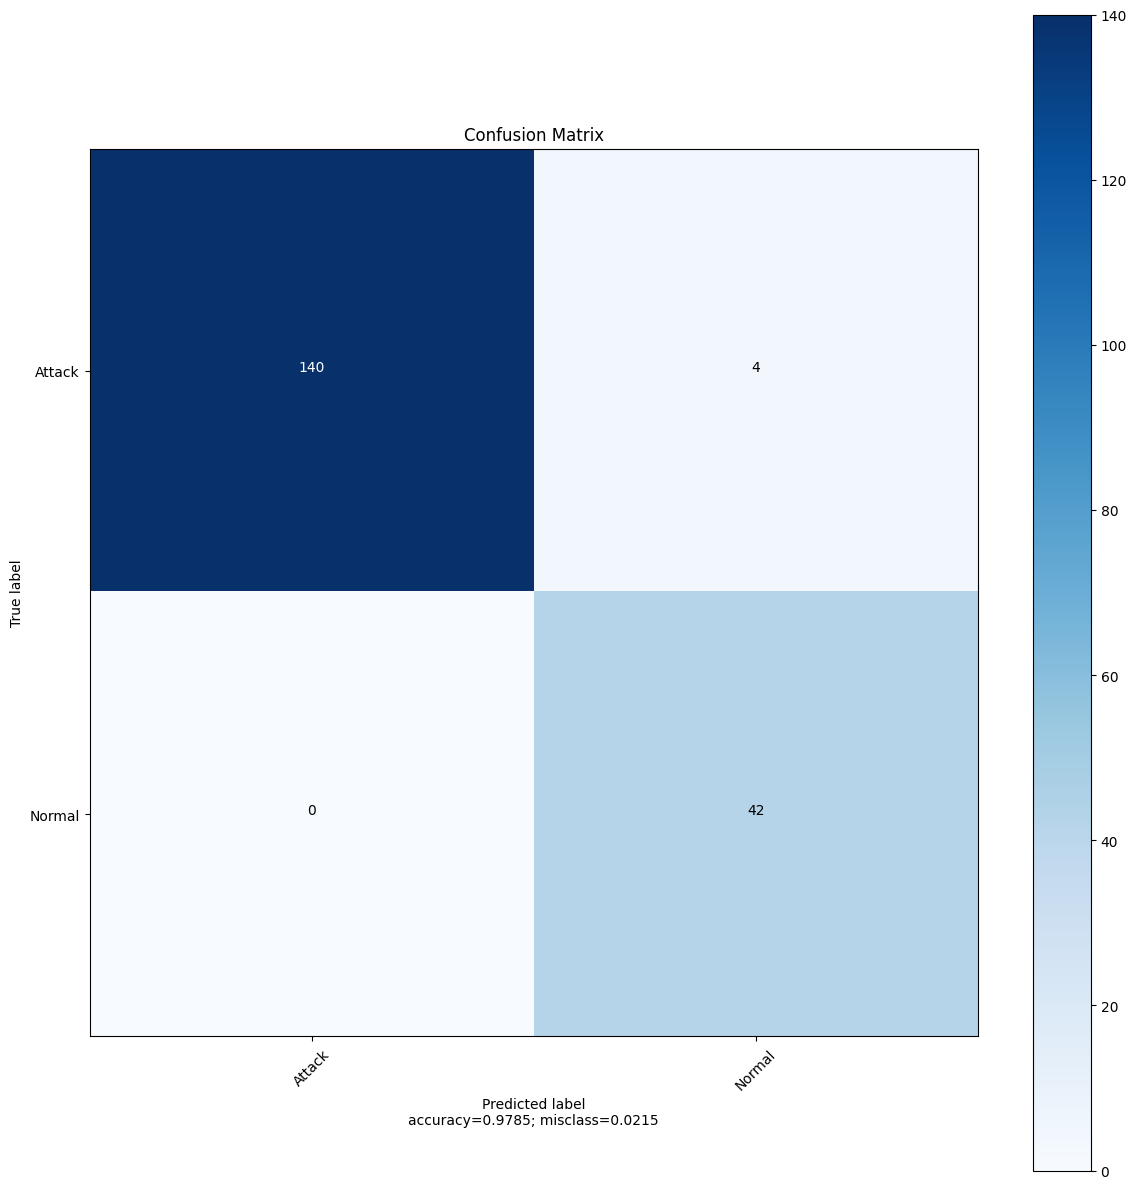

In [ ]:
from sklearn.metrics import confusion_matrix

plot_confusion_matrix(cm = confusion_matrix(actual, test_pred),
                      normalize    = False,
                      target_names = np.unique(actual),
                      title        = "Confusion Matrix")